In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import pingouin as pg
import scipy.stats as stats

In [2]:
window_size = 30

In [3]:
def get_data_dir(data_name : str) :
    curr_dir = os.getcwd()
    data_dir = curr_dir + "/" + data_name

    return data_dir

def get_data_dict( data_name ) :
    data_dir = get_data_dir(data_name)
    parti_list = os.listdir(data_dir)
    parti_list = [ x for x in parti_list if not x.startswith(".")]
    parti_dict = { x.split(sep='.')[0] : np.load(data_dir + "/" + x) if x.endswith(".npy") \
                  else pd.read_csv(data_dir + "/" + x, index_col=0 ) for x in parti_list}

    return parti_dict

def dict_sort( data_dict ) : 
    sorted_dict = dict(sorted(data_dict.items()))

    return sorted_dict

def key_str2int( data_dict ) : 
    data_dict = { int(key.split(sep='_')[0]) : value for key, value in data_dict.items() }

    return data_dict
    

def get_data_arr( data_dict) :
    
    data_dict = dict_sort(data_dict)

    arr = [ value for key, value in data_dict.items() ]

    arr = np.array(arr)

    return arr

def sliding_wind_mean( data_dict, wind_size = 30, video_len = 120 ) :

    window_means = []

    if wind_size != video_len :
        
        for data in data_dict :
            data_len = len(data_dict[data])
            frame_in_1s = max(30, round(data_len/video_len)) # frames in 1-sec could be 30 of 60 
            wind_frames = frame_in_1s*wind_size

            window_mean = []
            for ind in range(0,video_len-wind_size+1):
                if ind*frame_in_1s + wind_frames <= data_len :
                    window_mean.append(data_dict[data][ind*frame_in_1s:ind*frame_in_1s+wind_frames].mean(axis=0))
                else : window_mean.append(data_dict[data][ind*frame_in_1s:].mean(axis=0))
            window_means.append(np.array(window_mean))
    
    else: 
        for data in data_dict:
            window_means.append(data_dict[data].mean(0))
        

    return np.array(window_means)

def paired_t(data1, data2, alternative = 'greater' ) :
    '''
    funtion to conduct 'paired_t-test'

    Parameters:
    data1 : main data 
    data2 : comparing data to 
    alternavtive(sting) in ['two-sided','greater','less']
    
    Returns: t_val,dof,p_val,alternative

    '''

    df = pg.ttest(data1,data2,paired=True, alternative=alternative)
    t_val = df['T'].values[0]
    dof = df['dof'].values[0]
    p_val = df['p-val'].values[0]
    alternative = df['alternative'].values[0]
    
    return (t_val, dof, p_val, alternative)


def get_1st_increase( data ) :
    for ind in range(1,data.shape[1]) : 

        if data[:,0].mean() <= data[:,30].mean() : 
            t, dof, p, alt = paired_t(data[:,ind],data[:,0], alternative='greater' )

        else : t, dof, p, alt = paired_t(data[:,ind],data[:,0], alternative='less' )

        if( p < 0.05):
            print( "Index :", ind, "t-val :", t, "p-val :",p, 'alternative :', alt)
            break

def get_increase(data) : 
    std_index = 0
    alternative = 'greater' if data[:,0].mean() <= data[:,30].mean() else 'less'
    
    while std_index <= data.shape[1] :
        fin = std_index
        print("기준 Index : {0}".format(std_index) )
        
        for ind in range(std_index+1,data.shape[1]) : 

            t, dof, p, alt = paired_t(data[:,ind],data[:,std_index], alternative=alternative )

            if( p < 0.05):
                print( "Index :", ind, "t-val :", t, "p-val :",p, 'alternative :', alt)
                std_index = ind
                break
        
        if fin == std_index :
            print(f"{fin} 이후 유의미한 증가 없음")
            break
        print("-"*30)

In [4]:
parti_dict = get_data_dict('Dynamic_rating')
parti_arr = sliding_wind_mean(parti_dict, wind_size=window_size)

parti_arr.shape

(30, 91, 20)

(91,)


Text(0.5, 1.0, 'Blocks')

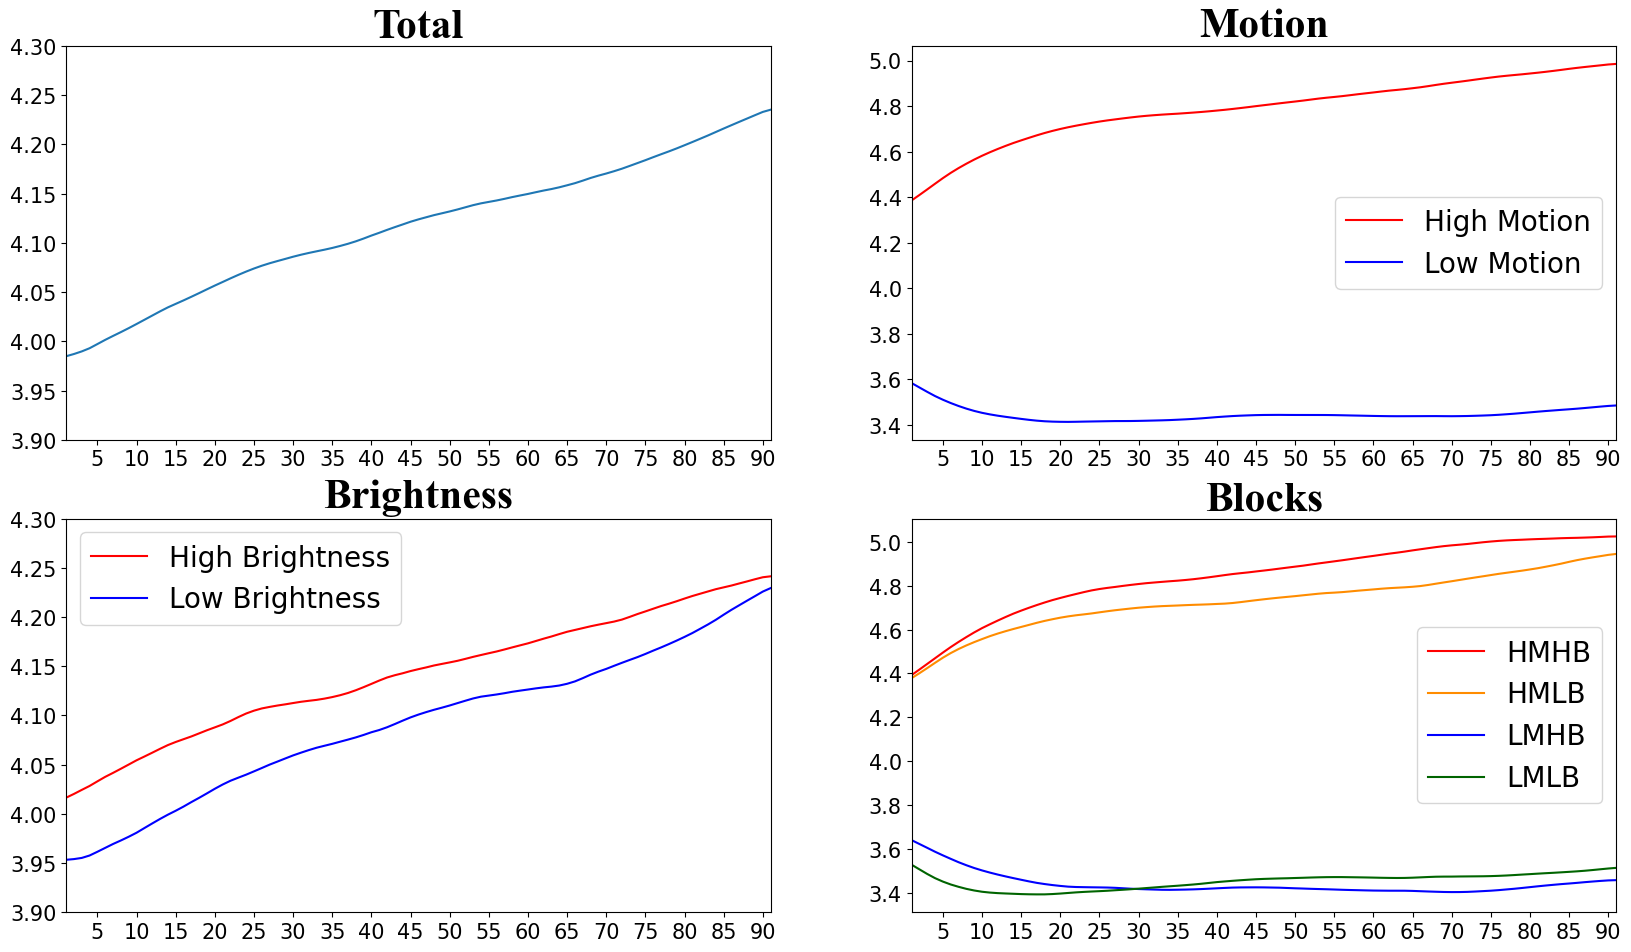

In [5]:
font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 30,
      'va' : 'center',
      'ha' : 'center' }


mean_arr = parti_arr.mean(axis=0).mean(axis=1)
print(mean_arr.shape)


HM_arr = parti_arr.mean(axis=0)[:,:10].mean(axis=1)
LM_arr = parti_arr.mean(axis=0)[:,10:].mean(axis=1)

HB_arr = parti_arr.mean(axis=0)[:,[0,1,2,3,4,10,11,12,13,14]].mean(axis=1)
LB_arr = parti_arr.mean(axis=0)[:,[5,6,7,8,9,15,16,17,18,19]].mean(axis=1)

HMHB_arr = parti_arr.mean(axis=0)[:,[0,1,2,3,4]].mean(axis=1)
HMLB_arr = parti_arr.mean(axis=0)[:,[5,6,7,8,9]].mean(axis=1)
LMHB_arr = parti_arr.mean(axis=0)[:,[10,11,12,13,14]].mean(axis=1)
LMLB_arr = parti_arr.mean(axis=0)[:,[15,16,17,18,19]].mean(axis=1)


fig, axs = plt.subplots(2,2)
fig.set_size_inches(20, 9/16*20)

axs[0,0].plot(range(1, len(mean_arr)+1), mean_arr)
axs[0,0].set_ylim(3.9,4.3)
axs[0,0].set_xlim(1,len(mean_arr))
axs[0,0].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5])
axs[0,0].tick_params(axis='both', labelsize=15)
axs[0,0].set_title('Total', fontdict = font_dict)



axs[0,1].plot(range(1,len(mean_arr)+1), HM_arr, color='r')
axs[0,1].plot(range(1,len(mean_arr)+1), LM_arr, color='b')
axs[0,1].set_xlim(1,len(mean_arr))
axs[0,1].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5])
axs[0,1].tick_params(axis='both', labelsize=15)
axs[0,1].legend(['High Motion', 'Low Motion'], fontsize=20)
axs[0,1].set_title('Motion', fontdict = font_dict)


axs[1,0].plot(range(1,len(mean_arr)+1), HB_arr, color='r')
axs[1,0].plot(range(1,len(mean_arr)+1), LB_arr, color='b')
axs[1,0].set_ylim(3.9,4.3)
axs[1,0].set_xlim(1,len(mean_arr))
axs[1,0].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5])
axs[1,0].tick_params(axis='both', labelsize=15)
axs[1,0].legend(['High Brightness', 'Low Brightness'], fontsize=20)
axs[1,0].set_title('Brightness', pad= 15 ,fontdict = font_dict)


axs[1,1].plot(range(1,len(mean_arr)+1), HMHB_arr, color='r')
axs[1,1].plot(range(1,len(mean_arr)+1), HMLB_arr, color='darkorange')
axs[1,1].plot(range(1,len(mean_arr)+1), LMHB_arr, color='b')
axs[1,1].plot(range(1,len(mean_arr)+1), LMLB_arr, color='darkgreen')
axs[1,1].set_xlim(1,len(mean_arr))
axs[1,1].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5])
axs[1,1].tick_params(axis='both', labelsize=15)
axs[1,1].legend(["HMHB", "HMLB", "LMHB",'LMLB'], fontsize=20)
axs[1,1].set_title('Blocks', fontdict = font_dict)


/var/folders/fh/81v8w9qd4nz223gjsn9cgr6h0000gn/T/ipykernel_1794/3526234297.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticks().round(2), family = 'Arial', fontsize=15)
/var/folders/fh/81v8w9qd4nz223gjsn9cgr6h0000gn/T/ipykernel_1794/3526234297.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticks().round(2), family = 'Arial', fontsize=15)


Text(7.5, 4.9, '(b)')

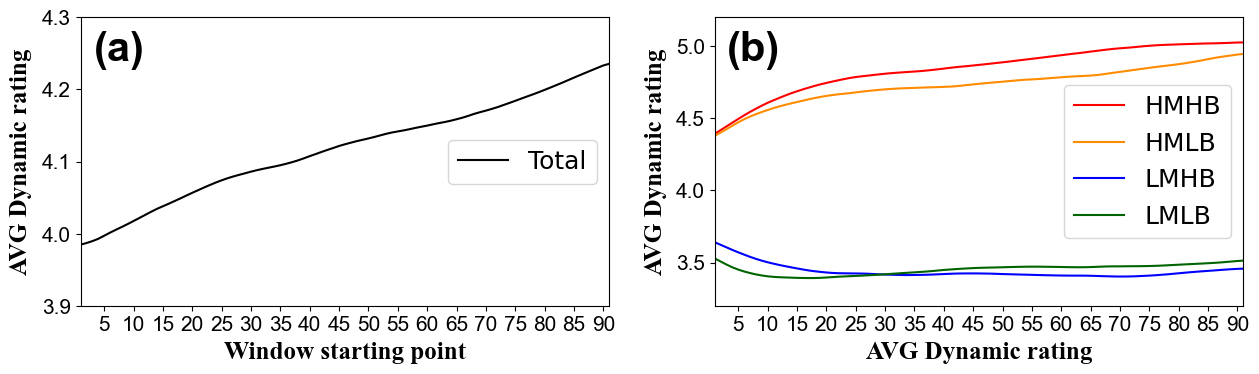

In [6]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 4/16* 15)

axs[0].plot(range(1, len(mean_arr)+1), mean_arr, color = 'black')
axs[0].set_ylim(3.9,4.3)
axs[0].set_xlim(1,len(mean_arr))
axs[0].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5], fontsize = 15, family = 'Arial' ) ; 
axs[0].tick_params(axis='y', labelsize=15)
axs[0].tick_params(axis='x', labelsize=13)
axs[0].set_xticklabels(axs[0].get_xticks().round(2), family = 'Arial', fontsize=15)
axs[0].set_yticklabels(axs[0].get_yticks().round(2), family = 'Arial', fontsize=15)
axs[0].legend(["Total"], loc = 5,fontsize = 18 )
axs[0].set_ylabel("AVG Dynamic rating", weight = 'bold',ha = 'center', va = 'center', fontsize = 18, family = 'Times New Roman', labelpad = 15)
axs[0].set_xlabel("Window starting point", weight = 'bold',ha='center', fontsize=18, family = 'Times New Roman', labelpad = 5)
axs[0].text(7.5,4.24,'(a)', ha ='center', fontsize = 30, family = 'Arial', weight='bold' )


axs[1].plot(range(1,len(mean_arr)+1), HMHB_arr, color='r')
axs[1].plot(range(1,len(mean_arr)+1), HMLB_arr, color='darkorange')
axs[1].plot(range(1,len(mean_arr)+1), LMHB_arr, color='b')
axs[1].plot(range(1,len(mean_arr)+1), LMLB_arr, color='darkgreen')
axs[1].tick_params(axis='y', labelsize=15)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].set_ylim(3.2,5.2)
axs[1].set_xlim(1,len(mean_arr))
axs[1].set_xticks([x for x in range(1,len(mean_arr)+1) if not x%5], family = 'Arial')
axs[1].set_xticklabels(axs[1].get_xticks().round(2), family = 'Arial', fontsize=15)
axs[1].set_yticklabels(axs[1].get_yticks().round(2), family = 'Arial', fontsize=15)
axs[1].set_ylabel("AVG Dynamic rating", weight = 'bold',ha = 'center', va = 'center', fontsize = 18, family = 'Times New Roman', labelpad = 15)
axs[1].legend(["HMHB", "HMLB", "LMHB",'LMLB'], fontsize=18)
axs[1].set_xlabel("AVG Dynamic rating", weight = 'bold',ha='center', fontsize=18, family = 'Times New Roman', labelpad = 5)
axs[1].text(7.5,4.9,'(b)', ha ='center', fontsize = 30, family = 'Arial', weight='bold' )






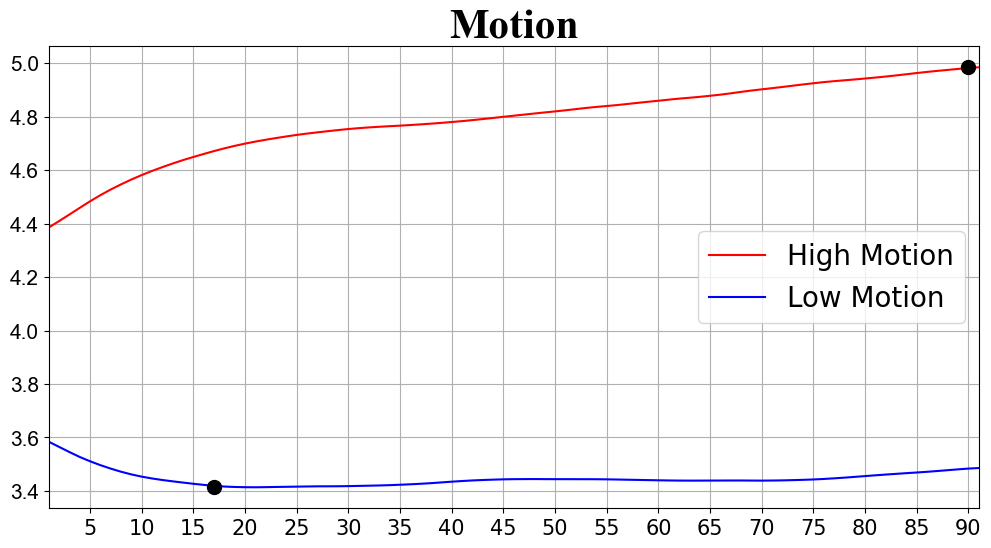

In [7]:
fig = plt.figure(figsize=(12,6))

plt.plot(range(1,len(mean_arr)+1), HM_arr, color='r')
plt.plot(range(1,len(mean_arr)+1), LM_arr, color='b')
plt.plot([17, 90], [LM_arr[17], HM_arr[90]], 'o', color='black', markersize=10 )
plt.xlim(1,len(mean_arr))
plt.xticks([x for x in range(1,len(mean_arr)+1) if not x%5], fontsize=15)
plt.yticks(family = 'Arial', fontsize = 15)
plt.legend(['High Motion', 'Low Motion'], fontsize=20)
plt.title('Motion', fontdict = font_dict)
plt.grid(True)

In [8]:
mean_arr = parti_arr.mean(axis=2)

HM_arr = parti_arr[...,:10].mean(axis=2)
LM_arr = parti_arr[...,10:].mean(axis=2)

HB_arr = parti_arr[...,[0,1,2,3,4,10,11,12,13,14]].mean(axis=2)
LB_arr = parti_arr[...,[5,6,7,8,9,15,16,17,18,19]].mean(axis=2)


HMHB_arr = parti_arr[...,[0,1,2,3,4]].mean(axis=2)
HMLB_arr = parti_arr[...,[5,6,7,8,9]].mean(axis=2)
LMHB_arr = parti_arr[...,[10,11,12,13,14]].mean(axis=2)
LMLB_arr = parti_arr[...,[15,16,17,18,19]].mean(axis=2)


arr_dict = { 'Mean' : mean_arr, "HM" : HM_arr, "LM" : LM_arr, "HB" : HB_arr, 'LB' : LB_arr, 
           "HMHB":HMHB_arr, "HMLB" : HMLB_arr, "LMHB" : LMHB_arr, "LMLB" : LMLB_arr }

print(mean_arr.shape)

(30, 91)


In [9]:
for key in arr_dict.keys():
    print(key)
    print("0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :")
    get_1st_increase(arr_dict[key])

    print("-"*30)
    


Mean
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 14 t-val : 1.726323273922314 p-val : 0.047464946009305446 alternative : greater
------------------------------
HM
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 1 t-val : 4.702281049188263 p-val : 2.8996043757189205e-05 alternative : greater
------------------------------
LM
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 1 t-val : -3.7977482406622194 p-val : 0.00034541955914288577 alternative : less
------------------------------
HB
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 21 t-val : 1.7235303553793138 p-val : 0.04772019333314063 alternative : greater
------------------------------
LB
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 15 t-val : 1.7582853272523784 p-val : 0.04462500816360006 alternative : greater
------------------------------
HMHB
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index : 1 t-val : 4.427086254572075 p-val : 6.208963916123557e-05 alternative : greater
------------------------------
HMLB
0번째 윈도우와 비교했을 때 값이 유의미하게 증가하는 타이밍 :
Index 

In [10]:
for key in arr_dict.keys():
    print(key)
    get_increase(arr_dict[key])
    print('='*100)


Mean
기준 Index : 0
Index : 14 t-val : 1.726323273922314 p-val : 0.047464946009305446 alternative : greater
------------------------------
기준 Index : 14
Index : 15 t-val : 2.381389823691382 p-val : 0.012015134945272534 alternative : greater
------------------------------
기준 Index : 15
Index : 16 t-val : 2.5294627349023373 p-val : 0.008558100044170108 alternative : greater
------------------------------
기준 Index : 16
Index : 17 t-val : 2.719505723145672 p-val : 0.005463768903368524 alternative : greater
------------------------------
기준 Index : 17
Index : 18 t-val : 2.8307463499610366 p-val : 0.004174868591079183 alternative : greater
------------------------------
기준 Index : 18
Index : 19 t-val : 2.6681822404506113 p-val : 0.006176334524161592 alternative : greater
------------------------------
기준 Index : 19
Index : 20 t-val : 2.436437659434742 p-val : 0.010603062559243998 alternative : greater
------------------------------
기준 Index : 20
Index : 21 t-val : 2.5485208055322492 p-val : 0.

In [11]:
for ind in range(HMHB_arr.shape[1]) : 
    data = np.array([HMHB_arr[:,ind], HMLB_arr[:, ind], LMHB_arr[:,ind], LMLB_arr[:,ind]]).T.flatten()
    blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(HMHB_arr)
    names = np.repeat(np.arange(30),4)
    print(f"[INDEX - {ind}]")
    
    df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})
    results = pg.anova( data= df, dv='rating', between='blocks' )
    if results['p-unc'].values[0] < 0.05 :
        print(results)


        post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')[['A','B','T','p-unc']].round(2)
        print("-"*100,'\n')
        print(post_hoc)
        print("="*100,'\n') 


[INDEX - 0]
   Source  ddof1  ddof2          F         p-unc       np2
0  blocks      3    116  14.554181  4.146400e-08  0.273468
---------------------------------------------------------------------------------------------------- 

      A     B     T  p-unc
0  HMHB  HMLB  0.22   0.83
1  HMHB  LMHB  5.99   0.00
2  HMHB  LMLB  5.89   0.00
3  HMLB  LMHB  5.35   0.00
4  HMLB  LMLB  5.76   0.00
5  LMHB  LMLB  1.16   0.25

[INDEX - 1]
   Source  ddof1  ddof2          F         p-unc       np2
0  blocks      3    116  14.862727  2.986549e-08  0.277655
---------------------------------------------------------------------------------------------------- 

      A     B     T  p-unc
0  HMHB  HMLB  0.25   0.81
1  HMHB  LMHB  6.06   0.00
2  HMHB  LMLB  5.94   0.00
3  HMLB  LMHB  5.42   0.00
4  HMLB  LMLB  5.82   0.00
5  LMHB  LMLB  1.16   0.25

[INDEX - 2]
   Source  ddof1  ddof2          F         p-unc       np2
0  blocks      3    116  15.177782  2.140148e-08  0.281882
------------------------

In [12]:
parti_arr.shape

(30, 91, 20)

In [13]:
feature_dict = get_data_dict('Feature')
v_dict = get_data_dict('HSV')

for key, value in feature_dict.items() : 
    feature_dict[key] = value[:3600]

feature_arr = sliding_wind_mean(feature_dict,window_size)
v_arr = sliding_wind_mean(v_dict,window_size)
rating_arr = parti_arr.mean(axis=0)

print(feature_arr.shape)
print(v_arr.shape)
print(rating_arr.shape)

(20, 91)
(20, 91, 256, 256)
(91, 20)


In [15]:
v_arr = v_arr.mean(axis=(2,3))
rating_arr = rating_arr.T

print(feature_arr.shape)
print(v_arr.shape)
print(rating_arr.shape)

(20, 91)
(20, 91)
(20, 91)
